# Cell 1: Cài đặt thư viện và kết nối Google Drive

In [ ]:
!pip install -q pycocotools
!pip install -q timm

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import timm
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 140.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 132.1 MB/s eta 0:00:00


In [ ]:
# Kết nối Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Kiểm tra thiết bị (ưu tiên GPU CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị đang sử dụng: {device}")

Thiết bị đang sử dụng: cpu


# Cell 2: Định nghĩa đường dẫn dataset


In [ ]:
# Đường dẫn đến dataset trong Google Drive
TRAIN_IMAGE_DIR = '/content/drive/MyDrive/COCO2017/train'
VAL_IMAGE_DIR = '/content/drive/MyDrive/COCO2017/val'
TRAIN_ANNOTATIONS = '/content/drive/MyDrive/COCO2017/annotations/instances_train2017.json'
VAL_ANNOTATIONS = '/content/drive/MyDrive/COCO2017/annotations/instances_val2017.json'

# Kiểm tra sự tồn tại của các thư mục và file
if not os.path.exists(TRAIN_IMAGE_DIR):
    raise FileNotFoundError(f"Thư mục {TRAIN_IMAGE_DIR} không tồn tại!")
if not os.path.exists(VAL_IMAGE_DIR):
    raise FileNotFoundError(f"Thư mục {VAL_IMAGE_DIR} không tồn tại!")
if not os.path.exists(TRAIN_ANNOTATIONS):
    raise FileNotFoundError(f"File {TRAIN_ANNOTATIONS} không tồn tại!")
if not os.path.exists(VAL_ANNOTATIONS):
    raise FileNotFoundError(f"File {VAL_ANNOTATIONS} không tồn tại!")

print("Đã xác nhận các đường dẫn dataset!")

Đã xác nhận các đường dẫn dataset!


# Cell 3: Định nghĩa dataset tùy chỉnh cho COCO


In [ ]:
class COCODataset(Dataset):
    def __init__(self, root, annotation_file, transform=None):
        self.root = root
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.cat_ids = self.coco.getCatIds()
        self.cat_to_idx = {cat_id: idx for idx, cat_id in enumerate(self.cat_ids)}

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Lấy nhãn đa nhãn
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        labels = torch.zeros(len(self.cat_ids))
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in self.cat_to_idx:
                labels[self.cat_to_idx[cat_id]] = 1

        if self.transform:
            image = self.transform(image)

        return image, labels

In [ ]:
# Danh sách các lớp (80 lớp của COCO 2017)
coco = COCO(TRAIN_ANNOTATIONS)
COCO_CLASSES = [cat['name'] for cat in coco.loadCats(coco.getCatIds())]
print(f"Số lớp: {len(COCO_CLASSES)}")

loading annotations into memory...
Done (t=28.02s)
creating index...
index created!
Số lớp: 80


# Cell 4: Định nghĩa biến đổi dữ liệu


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cell 5: Tạo dataset và DataLoader


In [ ]:
train_dataset = COCODataset(root=TRAIN_IMAGE_DIR, annotation_file=TRAIN_ANNOTATIONS, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

val_dataset = COCODataset(root=VAL_IMAGE_DIR, annotation_file=VAL_ANNOTATIONS, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Kích thước tập huấn luyện: {len(train_dataset)}")
print(f"Kích thước tập kiểm tra: {len(val_dataset)}")

loading annotations into memory...
Done (t=20.95s)
creating index...
index created!
loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
Kích thước tập huấn luyện: 118287
Kích thước tập kiểm tra: 5000


# Cell 6: Định nghĩa Multi-Head Attention


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()

        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(context)
        return output

# Cell 7: Định nghĩa mô hình CustomEfficientNet


In [ ]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        try:
            self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
            print("Tải trọng số pretrained thành công!")
        except Exception as e:
            print(f"Lỗi khi tải trọng số pretrained: {e}")
            self.base_model = timm.create_model('efficientnet_b0', pretrained=False)
            print("Khởi tạo mô hình với trọng số ngẫu nhiên.")

        self.conv_stem = self.base_model.conv_stem
        self.bn1 = self.base_model.bn1
        self.blocks = self.base_model.blocks
        self.conv_head = self.base_model.conv_head
        self.bn2 = self.base_model.bn2
        self.global_pool = self.base_model.global_pool

        # Lấy số kênh đầu ra từ các khối bằng cách forward một tensor mẫu
        self.feature_dims = []
        self.feature_sizes = []
        with torch.no_grad():
            x = torch.randn(1, 3, 224, 224)
            x = self.conv_stem(x)
            x = self.bn1(x)
            for block in self.blocks:
                x = block(x)
                self.feature_dims.append(x.size(1))  # Số kênh
                self.feature_sizes.append(x.size(2))  # Kích thước không gian (H)

        # Debug: In số kênh và kích thước không gian
        print("Số kênh của các khối:", self.feature_dims)
        print("Kích thước không gian của các khối:", self.feature_sizes)

        # Tầng convolution để chuẩn hóa đặc trưng (lấy 3 khối cuối)
        self.fusion_convs = nn.ModuleList([
            nn.Conv2d(dim, 320, kernel_size=1) for dim in self.feature_dims[-3:]
        ])

        # Tầng pooling để chuẩn hóa kích thước không gian về 7x7
        self.spatial_norm = nn.ModuleList([
            nn.AdaptiveMaxPool2d(output_size=7) for _ in range(3)
        ])

        # SE Block cho hợp nhất
        self.se_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(320 * 3, 320 // 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(320 // 8, 320 * 3, kernel_size=1),
            nn.Sigmoid()
        )

        # MHA
        self.mha = MultiHeadAttention(d_model=320 * 3, num_heads=8)

        # Tầng fully connected
        self.fc = nn.Linear(320 * 3, num_classes)

        # Đóng băng backbone
        for name, param in self.base_model.named_parameters():
            if "blocks.5" not in name:
                param.requires_grad = False

    def forward(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)

        # Lấy đặc trưng từ các khối
        features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i >= len(self.blocks) - 3:  # Lấy 3 khối cuối
                features.append(x)

        # Chuẩn hóa kích thước không gian và số kênh
        fused_features = []
        for feat, conv, norm in zip(features, self.fusion_convs, self.spatial_norm):
            feat = norm(feat)  # Chuẩn hóa kích thước không gian về 7x7
            feat = conv(feat)  # Chuẩn hóa số kênh về 320
            fused_features.append(feat)

        fused = torch.cat(fused_features, dim=1)  # [batch_size, 320*3, 7, 7]
        se_weights = self.se_block(fused)
        fused = fused * se_weights  # Áp dụng SE
        fused = self.global_pool(fused).squeeze(-1).squeeze(-1)  # [batch_size, 320*3]

        # Áp dụng MHA
        fused = fused.unsqueeze(1)  # [batch_size, 1, 320*3]
        fused = self.mha(fused)
        fused = fused.squeeze(1)  # [batch_size, 320*3]

        # Tầng fully connected
        x = self.fc(fused)
        return x

In [ ]:
# Khởi tạo mô hình
model = CustomEfficientNet(num_classes=len(COCO_CLASSES)).to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Tải trọng số pretrained thành công!
Số kênh của các khối: [16, 24, 40, 80, 112, 192, 320]
Kích thước không gian của các khối: [112, 56, 28, 14, 14, 7, 7]
CustomEfficientNet(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act

# Cell 8: Định nghĩa EarlyStopping


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.best_model_state = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Cell 9: Huấn luyện mô hình


In [ ]:
# Khởi tạo hàm mất mát, bộ tối ưu và EarlyStopping
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=3, min_delta=0)

In [ ]:
# Lưu trữ lịch sử huấn luyện
train_losses = []
val_losses = []
val_metrics = {'precision': [], 'recall': [], 'f1': [], 'auc': []}

In [ ]:
# Huấn luyện
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Đánh giá trên tập validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(np.int32)
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Tính các chỉ số đánh giá
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    auc_scores = []
    for i in range(all_labels.shape[1]):
        if np.sum(all_labels[:, i]) > 0:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
    auc = np.mean(auc_scores) if auc_scores else 0

    val_metrics['precision'].append(precision)
    val_metrics['recall'].append(recall)
    val_metrics['f1'].append(f1)
    val_metrics['auc'].append(auc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

In [ ]:
# Tải trạng thái mô hình tốt nhất
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)

    # Lưu mô hình vào Google Drive
    torch.save(model.state_dict(), '/content/drive/MyDrive/COCO2017/best_model.pth')

Đã tải trạng thái mô hình tốt nhất!
Đã lưu mô hình vào /content/drive/MyDrive/COCO2017/model_best.pth


# Cell 10: Đánh giá và trực quan hóa


In [ ]:
# Lấy một ảnh mẫu từ tập kiểm tra
img, true_labels = val_dataset[0]
img = img.unsqueeze(0).to(device)

# Dự đoán
model.eval()
with torch.no_grad():
    output = model(img)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()
    preds = (probs > 0.5).astype(np.int32)

In [ ]:
import matplotlib.pyplot as plt
import torch

# Hàm hiển thị ảnh tensor
def show_image(img_tensor):
    # Nếu ảnh có chuẩn hóa (ví dụ mean/std ImageNet), hãy denormalize ở đây
    # Giả sử ảnh không chuẩn hóa hoặc bạn đã denormalize trước

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # chuyển từ (C,H,W) sang (H,W,C)
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

# Hiển thị ảnh gốc
print("Ảnh gốc:")
show_image(img_tensor)

# Hiển thị nhãn dự đoán
threshold = 0.5
predicted_labels = [(COCO_CLASSES[i], probs[i]) for i in range(len(probs)) if probs[i] > threshold]
print("Nhãn dự đoán:")
for label, prob in predicted_labels:
    print(f"{label}: {prob:.4f}")

# Hiển thị nhãn thực tế
true_labels_np = true_labels.numpy()
print("Nhãn thực tế:")
for i in range(len(true_labels_np)):
    if true_labels_np[i] == 1:
        print(f"{COCO_CLASSES[i]}")


Nhãn dự đoán:
chair: 0.5886
couch: 0.6081
tv: 0.9569


In [ ]:
# Tính các chỉ số trên tập validation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(np.int32)
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
auc_scores = []
for i in range(all_labels.shape[1]):
    if np.sum(all_labels[:, i]) > 0:
        auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        auc_scores.append(auc)
auc = np.mean(auc_scores) if auc_scores else 0

print("\nKết quả đánh giá trên tập validation:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Kết quả đánh giá trên tập validation:
Precision: 0.7390
Recall: 0.5770
F1-Score: 0.6323
AUC: 0.7524


In [ ]:
# Lưu bảng kết quả
results = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'AUC'],
    'Value': [precision, recall, f1, auc]
}
results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/COCO2017/results_val.csv', index=False)

Đã lưu kết quả vào /content/drive/MyDrive/COCO2017/validation_results.csv


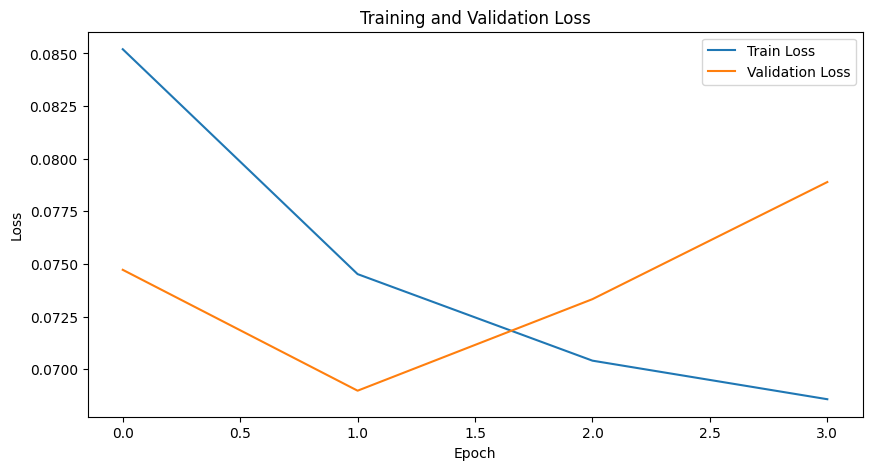

In [ ]:
# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/COCO2017/plot_loss.png')
plt.show()

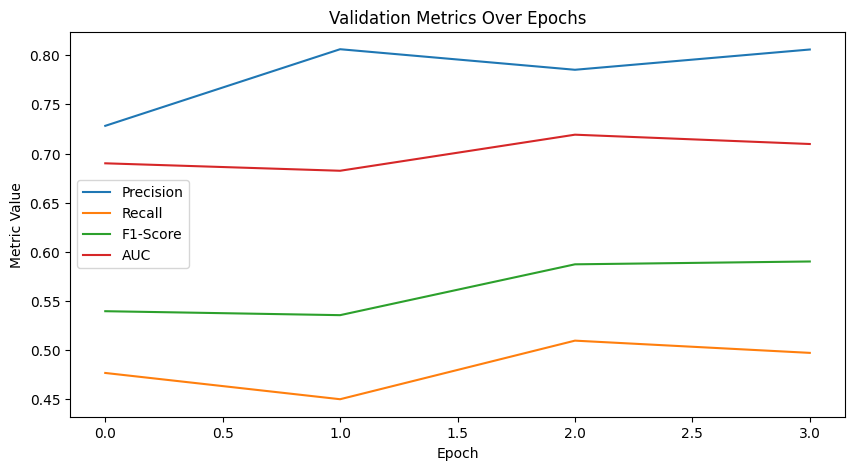

Đã lưu biểu đồ vào /content/drive/MyDrive/COCO2017/loss_plot.png và metrics


In [ ]:
# Vẽ biểu đồ các chỉ số
plt.figure(figsize=(10, 5))
plt.plot(val_metrics['precision'], label='Precision')
plt.plot(val_metrics['recall'], label='Recall')
plt.plot(val_metrics['f1'], label='F1-Score')
plt.plot(val_metrics['auc'], label='AUC')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.savefig('/content/drive/MyDrive/COCO2017/plot_metrics.png')
plt.show()